# importación de Librerias

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, accuracy_score,ConfusionMatrixDisplay

from sklearn.tree import export_graphviz
import graphviz

import mlflow
import os

# Lectura de archivo

In [2]:
MAIN_FOLDER = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path= os.path.join(MAIN_FOLDER, "data", "model", "ohe_customer_dataset.csv")

In [3]:
data = pd.read_csv(data_path, sep=',') 
data.head()

,transactionAmount,transactionFailed,fraudulent,orderAmount_10.0,orderAmount_11.0,orderAmount_12.0,orderAmount_13.0,orderAmount_14.0,orderAmount_15.0,orderAmount_16.0,...,emailDomain_net,emailDomain_org,emailDomain_weird,emailProvider_gmail,emailProvider_hotmail,emailProvider_other,emailProvider_weird,emailProvider_yahoo,customerIPAddressSimplified_digits_and_letters,customerIPAddressSimplified_only_letters
0,18,False,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1,26,False,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2,45,False,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
3,23,False,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
4,43,True,1,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


In [3]:
#xperimento mlflow
mlflow.set_experiment(experiment_name='proyecto_TM')

<Experiment: artifact_location='file:///c:/Users/tomasito/practica%20phyton/BootCamp/Consigna/data/mlruns/274412528510322518', creation_time=1750987377117, experiment_id='274412528510322518', last_update_time=1750987377117, lifecycle_stage='active', name='proyecto_TM', tags={}>

# Random Forest

In [4]:
#instancamos el modelo
X=data.drop(['fraudulent'], axis=1)
y=data['fraudulent']

In [5]:
y.value_counts()

fraudulent
2    455
0    107
1     61
Name: count, dtype: int64

In [6]:
#imprimimos la forma de los datos
print(X.shape,y.shape)

(623, 119) (623,)


In [7]:
### guardar shape en mlflow
mlflow.log_param('tamano de X',X.shape)
mlflow.log_param('tamano de y',y.shape)

(623,)

In [8]:
#instanciamos los pasos para el modelo
steps = [
    
    ('RFC', RandomForestClassifier( random_state=99, n_estimators=500))
]

In [9]:
#guardar Seed y estimators
mlflow.log_param('n_estimators',500)

mlflow.log_param("random_state", 99)
 
mlflow.log_param('tamaño de la muestra',30)




30

In [10]:
#instnaciamos el pipeline
pipeline=Pipeline(steps)

In [11]:
#instaciamos kfold
kf = KFold(n_splits=5, shuffle=True,random_state=42)

In [12]:
mlflow.log_param('kflod',kf)

KFold(n_splits=5, random_state=42, shuffle=True)

In [13]:
#instanciamos los parametros a probar
param_grid = {
    'RFC__class_weight': [None,'balanced']
}


In [14]:
#dividimos la data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30,random_state=42)

In [15]:
#instanciamos para conseguir los mejores parametros
GSCV = GridSearchCV(pipeline, param_grid=param_grid, cv=kf)

In [16]:
#Ajustamos el modelo
GSCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('RFC',
                                        RandomForestClassifier(n_estimators=500,
                                                               random_state=99))]),
             param_grid={'RFC__class_weight': [None, 'balanced']})

In [17]:
#calculamor el mejor score
GSCV.best_score_

0.905597493234582

In [18]:
#calulamoe el mejor parametro
GSCV.best_params_

{'RFC__class_weight': 'balanced'}

In [19]:
#guardar mejores parametros
mlflow.log_params(GSCV.best_params_)

In [20]:
# instanciamos el mejor estimador
RFCB=GSCV.best_estimator_

In [21]:
# guardar best model
mlflow.sklearn.log_model(GSCV.best_estimator_, "best_model")

2025/06/28 14:15:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/28 14:16:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
#ajustamos nuevamente con el mejor estimador
RFCB.fit(X_train, y_train)

Pipeline(steps=[('RFC',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, random_state=99))])

In [23]:
#calculamos el mejor score baseado en el mejor estimador en la data de testing
RFCB.score(X_test, y_test)

0.9

In [24]:
# guardar el score de data de testing
mlflow.log_metric("accuracy_test", RFCB.score(X_test, y_test))


In [25]:
#instanciamos y predecimos los datos de testing
y_pred=RFCB.predict(X_test)
y_pred

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 1], dtype=int64)

In [26]:
# Calculo de Acuracy de train
accuracy_train = accuracy_score(y_train, RFCB.predict(X_train))
print("Accuracy train:", accuracy_train)

Accuracy train: 1.0


In [27]:
mlflow.log_metric("accuracy_traing", accuracy_score(y_train, RFCB.predict(X_train)))

In [28]:
#calculo de confusion matrix
confusion_matrix(y_test,y_pred)

array([[ 3,  3,  0],
       [ 0,  1,  0],
       [ 0,  0, 23]], dtype=int64)

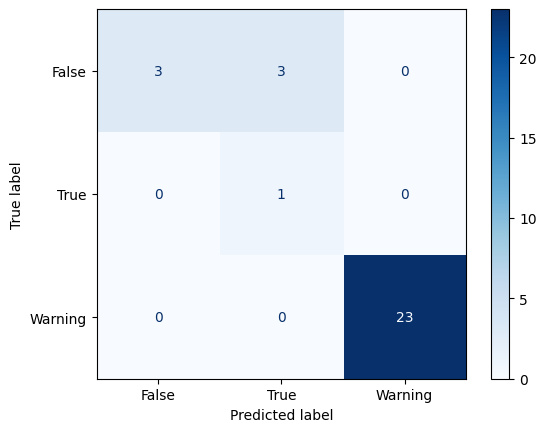

In [29]:
ConfusionMatrixDisplay.from_estimator(
    RFCB, X_test, y_test,
    display_labels=['False','True','Warning'],
    cmap='Blues',
    )

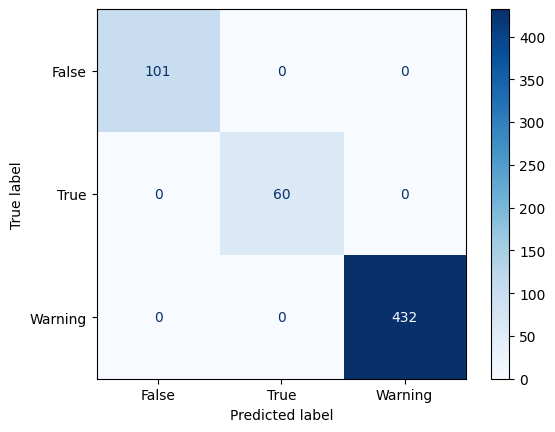

In [30]:
ConfusionMatrixDisplay.from_estimator(
    RFCB, X_train, y_train,
    display_labels=['False','True','Warning'],
    cmap='Blues',
    )

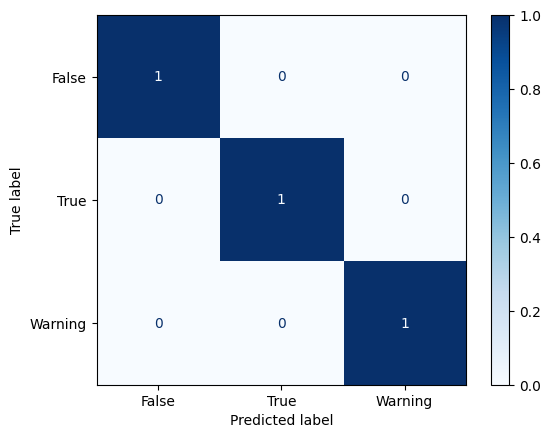

In [31]:

ConfusionMatrixDisplay.from_estimator(
    RFCB, X_train, y_train,
    display_labels=['False','True','Warning'],
    cmap='Blues',
    normalize='true',
    )

In [32]:
# calculo de clasification report
print(classification_report(y_test, y_pred, target_names=['False', 'True', 'Warning']))

              precision    recall  f1-score   support

       False       1.00      0.50      0.67         6
        True       0.25      1.00      0.40         1
     Warning       1.00      1.00      1.00        23

    accuracy                           0.90        30
   macro avg       0.75      0.83      0.69        30
weighted avg       0.97      0.90      0.91        30



In [33]:
# probilidad para multiclases
y_proba = GSCV.predict_proba(X_test)

In [34]:
#Area bajo la curva
roc_auc_score(y_test,y_proba, multi_class='ovr')

0.9597302043422733

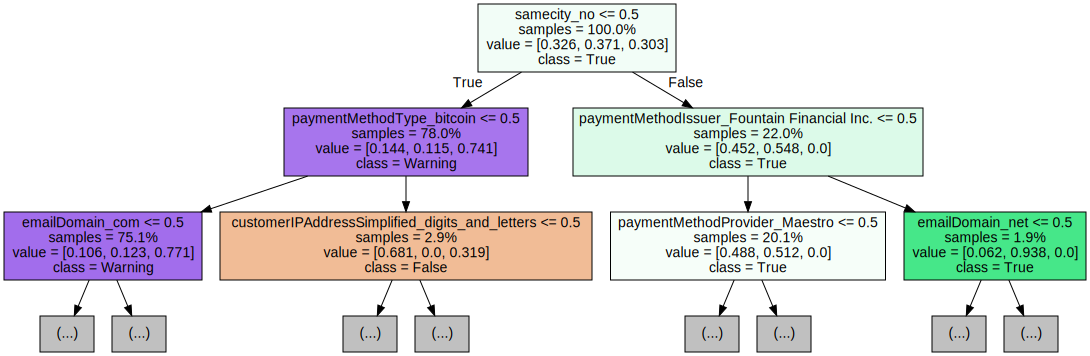

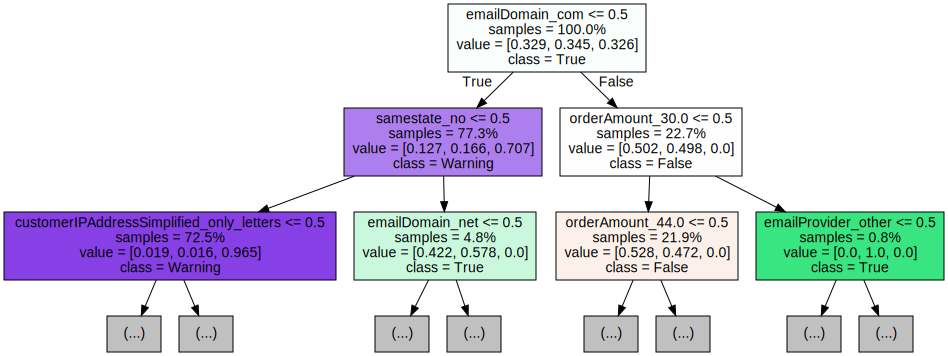

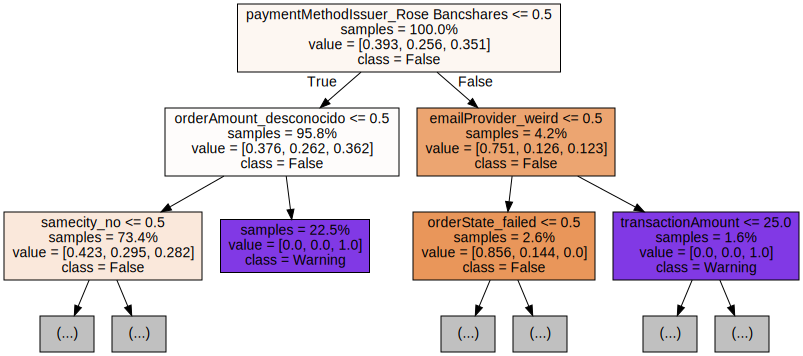

In [35]:
#graficar los arboles
rf = RFCB.named_steps['RFC']  

for i in range(3):  
    tree = rf.estimators_[i]

    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               class_names=['False', 'True', 'Warning'],
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)

    graph = graphviz.Source(dot_data)
    display(graph)

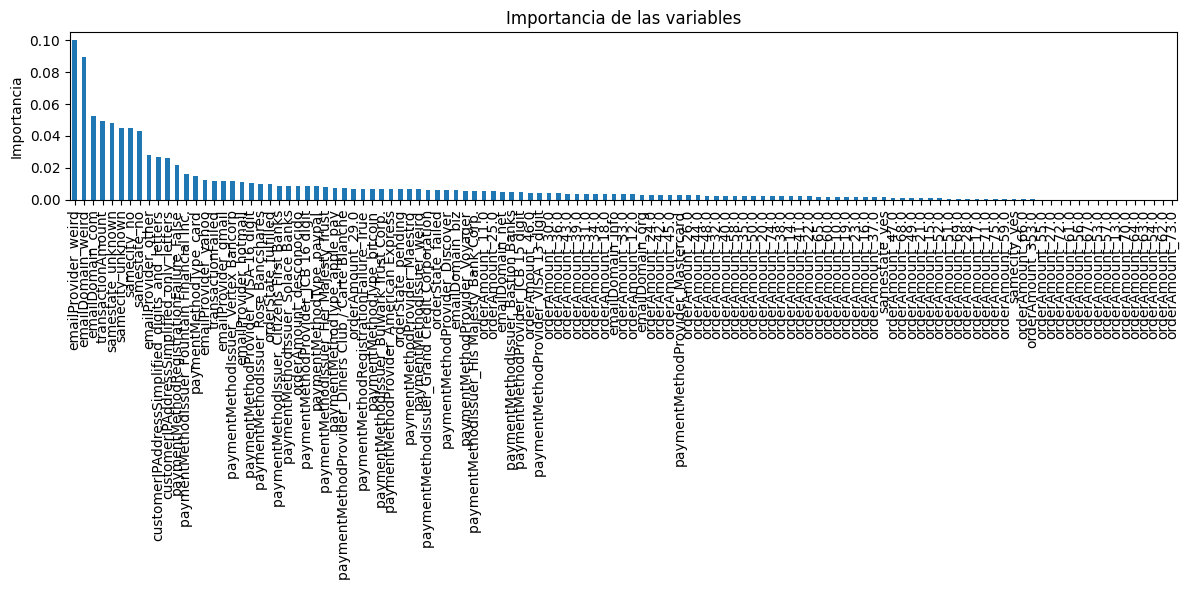

In [36]:
importancias = pd.Series(
    GSCV.best_estimator_.named_steps['RFC'].feature_importances_,
    index=X_train.columns
)

# Ordenamos de mayor a menor importancia
importancias.sort_values(ascending=False).plot.bar(figsize=(12,6))
plt.xticks(rotation=90)
plt.title('Importancia de las variables')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()


In [587]:
import pickle

In [ ]:
MAIN_FOLDER = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_path= os.path.join(MAIN_FOLDER, "data", "model", 'modelo_proyecto_final.pickle'

In [ ]:
# Guardar en el disco
pickle.dump(RFCB, open(model_path, 'wb')) 

In [589]:
#!mlflow ui